## FireNet YOLOv5 custom data set training

Adapted from https://blog.paperspace.com/train-yolov5-custom-data/#convert-the-annotations-into-the-yolo-v5-format

## Set up code

In [186]:
!git clone https://github.com/ultralytics/yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [187]:
%pip install -r yolov5/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [188]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [189]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

import csv

random.seed(108)
annotations_path = "..\data\FireNet_ObjectDetection"
images_path = "..\data\FireNet_Images"

## Convert the Annotations into the YOLO v5 Format

In [190]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [191]:
example_xml_file = os.path.join(annotations_path, "0000.xml")
print(extract_info_from_xml(example_xml_file))

{'bboxes': [{'class': 'Fire_Extinguisher', 'xmin': 265, 'ymin': 1018, 'xmax': 761, 'ymax': 1950}, {'class': 'Fire_Suppression_Signage', 'xmin': 495, 'ymin': 773, 'xmax': 692, 'ymax': 958}], 'filename': '0000.jpg', 'image_size': (1536, 2048, 3)}


In [192]:
labels_file = os.path.join('..\data', "FireNet_labels.csv")
with open(labels_file, mode='r') as in_file:
    reader = csv.reader(in_file)
    next(reader) # Skipping header 
    class_name_to_id_mapping = {rows[1]:(int(rows[0])-1) for rows in reader}
print(class_name_to_id_mapping)

{'Alarm_Activator': 0, 'Fire_Blanket': 1, 'Fire_Exit': 2, 'Fire_Extinguisher': 3, 'Fire_Suppression_Signage': 4, 'Flashing_Light_Orbs': 5, 'Sounders': 6, 'White_Domes': 7}


In [193]:
# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
            if(class_id == 8):
                print("oh no")
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
    
    # Name of the file which we have to save 
    save_file_name = os.path.join(annotations_path, info_dict["filename"].replace("jpg", "txt"))
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [194]:
# Get the annotations
annotations = [os.path.join(annotations_path, x) for x in os.listdir(annotations_path) if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join(annotations_path, x) for x in os.listdir(annotations_path) if x[-3:] == "txt"]

100%|██████████| 1452/1452 [00:01<00:00, 838.34it/s]


In [195]:
def plot_bounding_box(image, annotation_list,class_id_to_name_mapping):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)),outline ="green")
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[obj_cls],fill="green")
    
    plt.imshow(np.array(image))
    plt.show()


### Testing the annotations

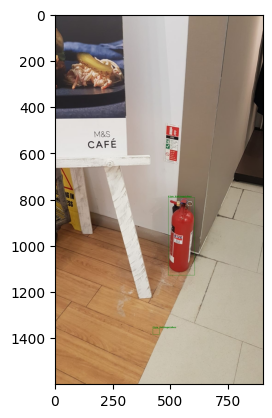

In [196]:
random.seed(32)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))
# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]


#Get the corresponding image file
image_file = annotation_file.replace("FireNet_ObjectDetection", "FireNet_Images").replace("txt", "jpg")
assert os.path.exists(image_file)
#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list,class_id_to_name_mapping)

## Partition the Dataset

In [197]:
# Read images and annotations
images = [os.path.join(images_path, x) for x in os.listdir(images_path)]
annotations = [os.path.join(annotations_path, x) for x in os.listdir(annotations_path) if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [198]:
#Utility function to copy images 
def copy_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.copy(f, destination_folder)
        except:
            print(f)
            assert False

In [199]:
# Copy the splits into their folders
os.makedirs('../data/images/train', exist_ok=True)
copy_files_to_folder(train_images, '../data/images/train')
os.makedirs('../data/images/val/', exist_ok=True)
copy_files_to_folder(val_images, '../data/images/val/')
os.makedirs('../data/images/test/', exist_ok=True)
copy_files_to_folder(test_images, '../data/images/test/')
os.makedirs('../data/labels/train/', exist_ok=True)
copy_files_to_folder(train_annotations, '../data/labels/train/')
os.makedirs('../data/labels/val/', exist_ok=True)
copy_files_to_folder(val_annotations, '../data/labels/val/')
os.makedirs('../data/labels/test/', exist_ok=True)
copy_files_to_folder(test_annotations, '../data/labels/test/')

## Config Files

In [200]:
shutil.copy("Fire_Detector.yaml", "yolov5/data")

'yolov5/data\\Fire_Detector.yaml'

## Train the Model

In [201]:
!python yolov5/train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch-low.yaml --batch 32 --epochs 100 --data Fire_Detector.yaml --weights yolov5s.pt --workers 24 --name yolo_road_det

^C
